# Logistic Regression
---
*By Ihza Gonzales*

## Libraries Used

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import regex as re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import pickle

import warnings
warnings.filterwarnings('ignore')

## Functions Implmented

In [2]:
#Function to define how a text is preprocessed for modeling
def custom_preprocessor (text):
    text = text.lower() #lowercases word
    text = re.sub(r'[^\w\s]', '', text) #removes punctuation
    text = re.sub(r'[0–9]', '', text) #removes any numbers
    text = re.sub('(<.*?>)', '', text) #removed html
    #copied from https://swatimeena989.medium.com/beginners-guide-for-preprocessing-text-data-f3156bec85ca
    
    lemmatizer = WordNetLemmatizer()
    text = lemmatizer.lemmatize(text)
    
    return text

#copied from https://www.studytonight.com/post/scikitlearn-countvectorizer-in-nlp

In [3]:
#Function for printing metrics and best parameters of models
def model_metrics(model, X_train, X_test):
    
    print(f'Best Score: {model.best_score_}')
    print(f'Best Parameters: {model.best_params_}')
    print(f'Train Score: {model.score(X_train, y_train)}')
    print(f'Test Score: {model.score(X_test, y_test)}')

In [4]:
#Function for plotting confusion matrix
def plot_matrix(model, X_test):
    
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    fig, ax = plt.subplots(figsize=(7, 7))
    
    # View confusion matrix
    plot_confusion_matrix(model, X_test, y_test, cmap = 'copper', values_format='d', ax = ax)
    
    # Labels, title and ticks
    label_font = {'size':'15'}  # Adjust to fit
    ax.set_xlabel('Predicted labels', fontdict=label_font);
    ax.set_ylabel('Observed labels', fontdict=label_font);

    title_font = {'size':'21'}  # Adjust to fit
    ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=12) 
    
#Copied from https://stackoverflow.com/questions/59839782/confusion-matrix-font-size

## Data Import

In [5]:
df = pd.read_csv('../anx_writing.csv').drop(columns = ['Unnamed: 0'], axis = 1)

In [6]:
df.head()

,author,link_flair_text,num_comments,subreddit,created_utc,text
0,JackW357,DAE Questions,9,Anxiety,1606687976,Anyone else scared of dying and scared of when...
1,belladoll1021,Health,1,Anxiety,1606687615,Tight throat Can a tight throat and gagging fe...
2,ashwinderegg,Advice Needed,3,Anxiety,1606687588,Anxiety overriding my intuition. Does anyone e...
3,ashwinderegg,Advice Needed,7,Anxiety,1606687588,Anxiety overriding my intuition. Does anyone e...
4,lachapoxxx,Advice Needed,1,Anxiety,1606687488,hey friends! i need some advice my anxiety has...


### Baseline Accuracy

In [7]:
df['subreddit'].value_counts(normalize = True)

Anxiety    0.5
writing    0.5
Name: subreddit, dtype: float64

In [8]:
#Add to the list of stopwords
stop = stopwords.words('english')

#These words were chosen through eda and from a warning from previously running program
new_words= ['writing','arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'thatll', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve', 'im', 'doe', 'ha', 'wa']

for i in new_words:
    stop.append(i)

#Copied from https://stackoverflow.com/questions/5511708/adding-words-to-nltk-stoplist

In [9]:
# Turn subreddit column to anxiety and no anxiety
df['subreddit'] = df['subreddit'].map({'Anxiety': 'Anxiety', 'writing': 'No Anxiety'})

In [10]:
X = df['text']
y = df['subreddit']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.7, stratify = y)

## Logistic Regression for Unigrams

In [12]:
pipe = Pipeline([
    ('tf', TfidfVectorizer(stop_words = stop, 
                           strip_accents = 'ascii', 
                           ngram_range = (1, 1),
                           preprocessor = custom_preprocessor,
                           min_df = 2,
                           max_features = 50000)),
    ('logr', LogisticRegression())
])

In [13]:
params = {
    'logr__penalty':['l1', 'l2', 'elasticnet'],
    'logr__solver': ['liblinear', 'sag', 'saga'],
    'logr__max_iter': [1000, 2000, 3000],
    'logr__C': [1, 2, 3]
}

grid = GridSearchCV(pipe, params, cv = 5, n_jobs = -1)

In [14]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(max_features=50000,
                                                        min_df=2,
                                                        preprocessor=<function custom_preprocessor at 0x7f9418c7de50>,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                    

In [15]:
model_metrics(grid, X_train, X_test)

Best Score: 0.9514285714285714
Best Parameters: {'logr__C': 3, 'logr__max_iter': 1000, 'logr__penalty': 'l2', 'logr__solver': 'saga'}
Train Score: 0.9921428571428571
Test Score: 0.9483333333333334


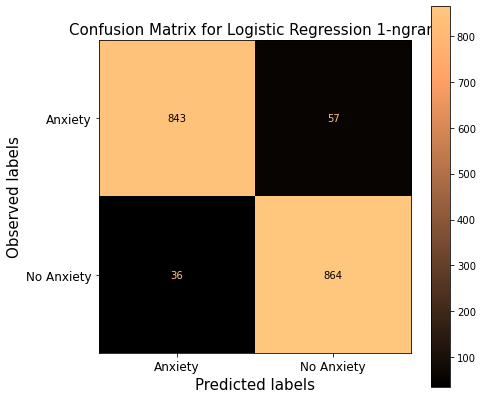

In [16]:
plot_matrix(grid, X_test)
plt.title('Confusion Matrix for Logistic Regression 1-ngram', fontsize = 15);

In [17]:
tvec = grid.best_estimator_.named_steps['tf']
log = grid.best_estimator_.named_steps['logr']
#Copied from https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn

coef_df = pd.DataFrame(log.coef_, columns = tvec.get_feature_names()).T
coef_df['coefficient'] = coef_df[0]
coef_df.drop(columns = 0, inplace = True)
coef_df.head()

,coefficient
11,0.020297
112k,0.021028
115,-0.058847
116,-0.010447
11th,-0.139334


In [18]:
words_1_gram = coef_df.sort_values(by = 'coefficient')

words_1_gram.to_csv('word_1_gram.csv')

### Saving Model

In [19]:
with open('./models/anxiety_log_1ngram.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(grid, pickle_out)